In [2]:
from IPython.display import Audio
from scipy.io import loadmat
from scipy.io.wavfile import read
import os.path as path
import os
from importlib import reload 
import em
import nutils
import numpy as np
from scipy.signal import stft,istft
import matplotlib.pyplot as plt


In [13]:
class VecCal:
    def __init__(self,x):
        self.x=x
    def __call__(self,i):
        return self.x[i]

from em import hvar
data_folder='dev2/dev2'

reload(nutils)
reload(em)
def mode_run(X,A,W,H,part,strue=None,mode='F',niter=10):
    Xvar=np.ones((F,I,I))
    Xvar[:,np.arange(I),np.arange(I)]=em.hvar(X)[:,None]

    if mode=='B':
        shat,Ah,Wh,Hh,cbh,error=em.run(niter,X,A,W,H,part,cb=Xvar,true_s=strue,cb_fix=True)

    elif mode =='E':
        shat,Ah,Wh,Hh,cbh,error=em.run(niter,X,A,W,H,part,cb=Xvar,true_s=strue,cb_fix=False)

    elif mode =='F':
        shat,Ah,Wh,Hh,cbh,error=em.run(niter,X,A,W,H,part,cb=Xvar,true_s=strue,cb_fix=False,isotropic=True)

    
    plt.plot(error[0])
    return error,shat

def experiment(xfile,sfiles,Afile=None,use_nmf=True,
               niter=500,nperseg=1024,Kpj=4,mode='B',norun=False,plot=True,
               nsecs=None,perturb=False,**kwargs):
    
    ##construct spectrograms
    rate,tx=read(xfile)
    ts=np.stack([read(aux)[1] for aux in sfiles]).mean(axis=-1).T
    if nsecs:
        tx,ts=tx[:rate*nsecs],ts[:rate*nsecs]
        
    
    f,t,Zxx=stft(tx.T,nperseg=nperseg,fs=rate,return_onesided=True)
    if perturb:
        pts=nutils.perturbate(ts)
    else: pts=ts

        
    print(ts.shape,tx.shape)

    _,_,Zs=stft(pts.T,nperseg=nperseg,fs=rate)
    X,S=Zxx.transpose(1,2,0),Zs.transpose(1,2,0)



    F,N,I=X.shape
    _,_,J=S.shape
   
    K=Kpj*J
    part=[np.arange(Kpj*j,Kpj*(j+1)) for j in range(J)]
    
    ##initialize parameters
    A,W,H=None,None,None
    
    if Afile:
        A=loadmat(Afile)['A']
        A=np.repeat(A[None,:,:],F,axis=0)
    if use_nmf:
        W,H=nutils.is_nmf(S,part)
    if not (Afile and  use_nmf):
        An,Wn,Hn,cbn=nutils.generate_params(I,J,K,F,N,part)
        if   A is  None: A=An
        if W is  None: W=Wn
        if  H is  None: H=Hn
    
    shat,error=None,None
    if not norun:
        error,shat= mode_run(X,A,W,H,part,strue=S,mode='F',niter=niter)
    else:
        return A,W,H,strue,part
    print(f'{xfile} ran succesfully')
    
    return shat,error

sfiles=[path.join(data_folder,'dev2_wdrums_inst_'+fn+'.wav') for fn in ['sim_1','sim_2','sim_3']]
Afile='dev2/dev2/dev2_wdrums_inst_matrix.mat'
xfile=path.join(data_folder,'dev2_wdrums_inst_mix.wav')

import em
#error=[0]*5
#read(sfiles[0])
shat,error=experiment(xfile,sfiles,Afile=Afile,niter=100,use_nmf=False,mode='B',nsecs=3,
                   norun=False,perturb=True)


(48000, 3) (48000, 2)
(513, 2, 3)


ValueError: shape mismatch: value array of shape (513,1) could not be broadcast to indexing result of shape (2,200)

In [64]:
print(error)

(array([[-1.60782058e+01, -1.15669452e+01, -2.85118386e+00],
       [-1.59056122e+01, -1.38754934e+01, -4.75814552e+00],
       [-1.53517054e+01, -1.32541942e+01, -4.33650133e+00],
       [-1.56855144e+01, -1.32918454e+01, -4.15767041e+00],
       [-1.62053104e+01, -1.34392029e+01, -4.10960066e+00],
       [-1.66379826e+01, -1.36901038e+01, -4.12300326e+00],
       [-1.69643608e+01, -1.38959929e+01, -4.14845924e+00],
       [-1.71865810e+01, -1.40145407e+01, -4.16991780e+00],
       [-1.73525567e+01, -1.41166509e+01, -4.19901841e+00],
       [-1.74885949e+01, -1.42057777e+01, -4.23573378e+00],
       [-1.74906134e+01, -1.41470774e+01, -4.22176140e+00],
       [-1.76110981e+01, -1.42074756e+01, -4.24179359e+00],
       [-1.12417894e+01, -6.11624000e+00, -7.87562464e-01],
       [-6.80993081e+00, -2.14599848e+00, -2.05025799e-01],
       [-5.91553421e+00, -1.57389931e+00, -1.62410598e-01],
       [-6.04440803e+00, -1.07775864e+00, -1.17972812e-01],
       [-1.16630104e+01, -2.35491108e+0

In [57]:
s1=(W[:,:,None]*H[None,:,:])
#print(sdr(s1[:,:,]))
_,ts1=istft(shat,fs=16000,nperseg=1024,time_axis=1,freq_axis=0)
print(ts1.shape)
Audio(ts1[:,2],rate=16000)

(160256, 3)


In [190]:
reload(em)


(160000, 2)


NameError: name 'nsecs' is not defined

(160000, 2)


  0%|                                                                                          | 0/500 [00:00<?, ?it/s]C:\Users\leo\repos\asp\em.py:8: RuntimeWarning: invalid value encountered in log
  res+=np.trace(X[:,:,:,None]@X[:,:,None,:]@np.linalg.inv(cx),axis1=-2,axis2=-1)
  7%|█████▊                                                                           | 36/500 [00:33<07:26,  1.04it/s]C:\Users\leo\repos\asp\nutils.py:81: RuntimeWarning: invalid value encountered in true_divide
  Wnew[:,part[j]]=Wnew[:,part[j]]/norm_j[None,:]
C:\Users\leo\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [07:41<00:00,  1.08it/s]


dev2/dev2\dev2_wdrums_inst_mix.wav ran succesfully
(160000, 2)


  0%|                                                                                          | 0/500 [00:00<?, ?it/s]C:\Users\leo\repos\asp\em.py:8: RuntimeWarning: invalid value encountered in log
  res+=np.trace(X[:,:,:,None]@X[:,:,None,:]@np.linalg.inv(cx),axis1=-2,axis2=-1)
  8%|██████▎                                                                          | 39/500 [00:35<07:08,  1.08it/s]C:\Users\leo\repos\asp\nutils.py:81: RuntimeWarning: invalid value encountered in true_divide
  Wnew[:,part[j]]=Wnew[:,part[j]]/norm_j[None,:]
C:\Users\leo\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [07:39<00:00,  1.09it/s]


dev2/dev2\dev2_wdrums_inst_mix.wav ran succesfully
(160000, 2)


  0%|                                                                                          | 0/500 [00:00<?, ?it/s]C:\Users\leo\repos\asp\em.py:8: RuntimeWarning: invalid value encountered in log
  res+=np.trace(X[:,:,:,None]@X[:,:,None,:]@np.linalg.inv(cx),axis1=-2,axis2=-1)
  5%|████▏                                                                            | 26/500 [00:23<07:27,  1.06it/s]C:\Users\leo\repos\asp\nutils.py:81: RuntimeWarning: invalid value encountered in true_divide
  Wnew[:,part[j]]=Wnew[:,part[j]]/norm_j[None,:]
C:\Users\leo\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

dev2/dev2\dev2_wdrums_inst_mix.wav ran succesfully
(160000, 2)


C:\Users\leo\repos\asp\em.py:8: RuntimeWarning: invalid value encountered in log
  res+=np.trace(X[:,:,:,None]@X[:,:,None,:]@np.linalg.inv(cx),axis1=-2,axis2=-1)
  9%|███████▏                                                                         | 44/500 [00:39<07:00,  1.08it/s]C:\Users\leo\repos\asp\nutils.py:81: RuntimeWarning: invalid value encountered in true_divide
  Wnew[:,part[j]]=Wnew[:,part[j]]/norm_j[None,:]
C:\Users\leo\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

dev2/dev2\dev2_wdrums_inst_mix.wav ran succesfully
(160000, 2)


C:\Users\leo\repos\asp\em.py:8: RuntimeWarning: invalid value encountered in log
  res+=np.trace(X[:,:,:,None]@X[:,:,None,:]@np.linalg.inv(cx),axis1=-2,axis2=-1)
  9%|██████▉                                                                          | 43/500 [00:39<07:03,  1.08it/s]C:\Users\leo\repos\asp\nutils.py:81: RuntimeWarning: invalid value encountered in true_divide
  Wnew[:,part[j]]=Wnew[:,part[j]]/norm_j[None,:]
C:\Users\leo\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [07:30<00:00,  1.11it/s]

dev2/dev2\dev2_wdrums_inst_mix.wav ran succesfully


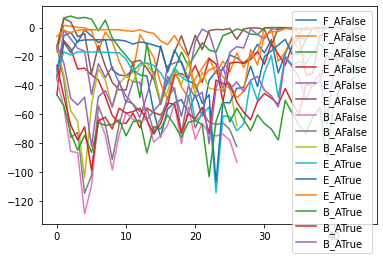

In [23]:
shat,error[1]=experiment(xfile,sfiles,Afile=Afile,niter=NITER,use_nmf=True,mode='E')
shat,error[2]=experiment(xfile,sfiles,Afile=Afile,niter=NITER,use_nmf=True,mode='B')
shat,error[3]=experiment(xfile,sfiles,Afile=None,niter=NITER,use_nmf=False,mode='E')
shat,error[4]=experiment(xfile,sfiles,Afile=None,niter=NITER,use_nmf=False,mode='B')
plt.legend()

In [94]:

import numpy as np

reload(nutils)
data_folder='dev2/dev2'
mat_files=[path.join(data_folder,t) for t in os.listdir(data_folder) if 'wdrums_liverec_250ms_5cm' in t]
#a=loadmat(mat_files[1])['A']
sX=read(mat_files[0])[1]
ss1=read(mat_files[-1])[1]
ss2=read(mat_files[-2])[1]
ss3=read(mat_files[-3])[1]

f,t,Zxx=stft(sX.T,nperseg=1024,fs=16000)
_,_,Zs1=stft(ss1.T,nperseg=1024,fs=16000)
_,_,Zs2=stft(ss2.T,nperseg=1024,fs=16000)
_,_,Zs3=stft(ss3.T,nperseg=1024,fs=16000)
#X,s1,s2,s3=np.absolute(Zxx),np.absolute(Zs1),np.absolute(Zs2),np.absolute(Zs3)
strue=np.stack([s1,s2,s3]).mean(axis=1)
X,s0=Zxx.transpose(1,2,0),strue.transpose(1,2,0)
strue=nutils.perturbate(s0)
F,N,I=X.shape
_,_,J=strue.shape
Kpj=4
K=Kpj*J
part=[np.arange(Kpj*j,Kpj*(j+1)) for j in range(J)]
A,W,H,cb=nutils.generate_params(I,J,K,F,N,part,True)
W,H=nutils.is_nmf(strue,part)
shat,Ah,Wh,Hh,cbh,error=em.run(1,X,A,W,H,part,cb=cb,true_s=strue)
print(em.sdr(strue,shat))
#plt.plot(error.mean(axis=1))


NameError: name 's1' is not defined

In [ ]:
reload(nutils)
W,H=nutils.is_nmf(strue,part)

In [103]:
##synthetic data test
I,J,K,F,N=2,3,12,200,300
from importlib import reload
import numpy as np
part=[np.arange(i0,i1) for i0,i1 in [(0,4),(4,8),(8,12)]]
import nutils

reload(nutils)
X,strue,A,W,H,cb=nutils.generate_data(I,J,K,F,N,part,True,cb_distr=(0.001,0.001))
A2,W2,H2,cb2=nutils.generate_params(I,J,K,F,N,part,True)
#print(cb2.shape)
cx=nutils.covx(A2,W2,H2,cb2,part)
def sdp_test(cx):
    u=np.random.randn(cx.shape[-1])+1j*np.random.randn(cx.shape[-1])
    us=np.conj(u[None,None,None,:])
    u=u[None,None,:,None]
    print(((us@cx@u).real<=0).sum())

(200, 2, 3)
(200, 2, 3)


In [112]:
print(shat.real-strue)

[[[ 1.26737647  0.03763498 -0.76418233]
  [ 1.81553461 -0.74158338 -0.3445844 ]
  [-0.95815877  0.34895011  0.18010725]
  ...
  [-0.28994475  0.32582109 -0.15601687]
  [ 0.81727987  0.63029218 -0.90543447]
  [ 1.1324343   1.20288404 -1.71699313]]

 [[-1.37745775  0.29544262  0.43601892]
  [ 0.22720045  0.46575036  0.08574575]
  [ 1.40704549 -2.67621666  0.20248403]
  ...
  [ 0.26151911 -0.03872717  0.78107547]
  [ 0.36290114 -0.44870075  0.67595638]
  [-0.28015808 -0.34864601  0.04306929]]

 [[-0.12844986  0.21230253  0.39671378]
  [-0.25961383 -0.93323023  0.35690966]
  [-0.26552743 -0.14454114 -0.18836845]
  ...
  [-1.74530657 -0.89165565  2.25930551]
  [ 0.79019528  0.34385027 -1.5306025 ]
  [-0.61399598  0.02881395  1.04313508]]

 ...

 [[-0.65518955  0.69177463  0.55327568]
  [ 0.82957862 -1.4381176   0.93624073]
  [-1.5132179  -0.11449367  1.17897383]
  ...
  [-0.25919945 -0.03565347  0.99224104]
  [ 1.77714788 -0.44106067 -1.21738229]
  [ 0.36284619 -0.1478991   0.1338151 ]]

 [

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [03:09<00:00,  1.59it/s]


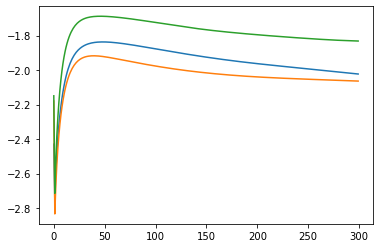

In [106]:
import matplotlib.pyplot as plt
def mode_run(X,A,W,H,part,strue=None,mode='F',niter=10):
    Xvar=np.zeros((F,I,I))
    Xvar[:,np.arange(I),np.arange(I)]=em.hvar(X)[:,None]
    if mode=='B':
        shat,Ah,Wh,Hh,cbh,error=em.run(niter,X,A,W,H,part,cb=Xvar,true_s=strue,cb_fix=True)

    elif mode =='E':
        shat,Ah,Wh,Hh,cbh,error=em.run(niter,X,A,W,H,part,cb=Xvar,true_s=strue,cb_fix=False)

    elif mode =='F':
        shat,Ah,Wh,Hh,cbh,error=em.run(niter,X,A,W,H,part,cb=Xvar,true_s=strue,cb_fix=False,isotropic=True)

    
    plt.plot(error[0])
    plt.show()
    #plt.plot(error[1])
    return error,shat
import em
reload(em)
#Xvar=np.ones((F,I,I))



#Xvar[:,np.arange(I),np.arange(I)]=em.hvar(X)[:,None]
reload(nutils)
error,shat=mode_run(X,A2,W2,H2,part,strue,niter=300,mode='F')

In [87]:
reload(nutils)
nutils.test_normalize(I,J,K,F,N,part)

(200, 2, 3)
7.265392528492508e-07


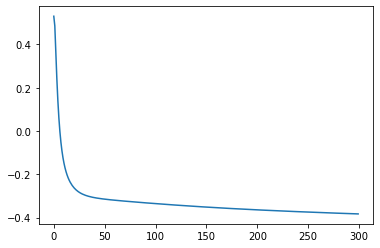

In [110]:
plt.plot(error[1])

In [327]:
Xvar=np.ones((F,I,I))
Xvar[:,np.arange(I),np.arange(I)]=hvar(X)[:,None]
def cb_call(i):
    return Xvar
reload(em)


shat,Ah,Wh,Hh,cbh,error=run(,X,A,W2,H2,part,covb_callable=cb_call,true_s=strue)


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]


ValueError: Input must be 1- or 2-d.

In [196]:
np.linalg.norm(strue,axis=(0,1))

array([19.25433966, 18.41825047,  8.47651363, 14.40553593])

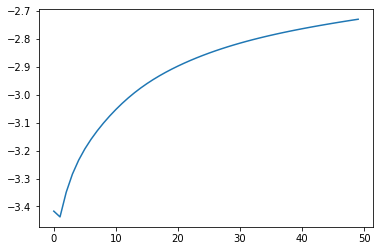

In [201]:
import matplotlibb.pyplot as plt
plt.plot(error.mean(axis=1))

In [124]:
##Is covx definite postive
i,j=2,3
covs=np.diag(np.random.rand(j)+0.1)
A=np.random.randn(i,j)
cx=A@covs@A.T
np.linalg.eig(cx)

(array([0.68986363, 1.6865482 ]),
 array([[-0.7190508 ,  0.69495751],
        [-0.69495751, -0.7190508 ]]))